In [1]:
!pip install pyspark

In [0]:
%matplotlib inline
import numpy as np
from math import sqrt
import pyspark
from pyspark.sql import SQLContext,SparkSession
from pyspark.sql.types import StructType,IntegerType, StructField, FloatType, DecimalType
from pyspark.sql.functions import stddev
from pyspark import SparkContext, SparkConf
import matplotlib.pyplot as plt
from pyspark.mllib.clustering import KMeans
from pyspark.ml.clustering import KMeans
import pyspark.sql.functions as functions

from pyspark.sql import Window
from pyspark.sql.window import Window
from pyspark.sql import Row
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as F

import matplotlib.pyplot as plt

In [0]:
sc = SparkSession \
    .builder \
    .appName("Q1 part b") \
    .getOrCreate()

In [0]:
import pyspark.sql.functions as functions
text = sc.sparkContext.textFile("sunspots.txt")
filedf = text.map(lambda x : x.split("\t"))
df = sc.createDataFrame(filedf).toDF("Count","Sunspots")
df = df.withColumn("Count",df["Count"].cast(IntegerType()))
df = df.withColumn("Sunspots",df["Sunspots"].cast(FloatType()))



In [23]:

w = Window.orderBy("Count")
df = df.withColumn("col",functions.lit(1))
windows = Window.partitionBy(df["col"]).orderBy(df["Count"]).rowsBetween(-1,1)
moving_average = functions.avg("Sunspots").over(windows)
df = df.withColumn("MovingAverage",moving_average)
df.show()

+-----+--------+---+------------------+
|Count|Sunspots|col|     MovingAverage|
+-----+--------+---+------------------+
|    0|    58.0|  1| 60.29999923706055|
|    1|    62.6|  1| 63.53333282470703|
|    2|    70.0|  1|62.766666412353516|
|    3|    55.7|  1| 70.23333358764648|
|    4|    85.0|  1| 74.73333358764648|
|    5|    83.5|  1| 87.76666768391927|
|    6|    94.8|  1| 81.53333536783855|
|    7|    66.3|  1| 79.00000254313152|
|    8|    75.9|  1| 72.56666819254558|
|    9|    75.5|  1|103.33333587646484|
|   10|   158.6|  1|106.43333435058594|
|   11|    85.2|  1| 105.7000020345052|
|   12|    73.3|  1| 78.13333384195964|
|   13|    75.9|  1| 79.46666717529297|
|   14|    89.2|  1| 84.46666717529297|
|   15|    88.3|  1| 89.16666666666667|
|   16|    90.0|  1| 92.76666768391927|
|   17|   100.0|  1|  91.8000005086263|
|   18|    85.4|  1| 96.13333384195964|
|   19|   103.0|  1|  93.1999994913737|
+-----+--------+---+------------------+
only showing top 20 rows



In [0]:
df = df.withColumn("Residual", (df.Sunspots-df.MovingAverage)*(df.Sunspots-df.MovingAverage))
std = df.select(functions.sqrt(functions.sum(df.Residual)/df.count()).alias("STD"))
df =df.crossJoin(std)

df_kmeans = df["Sunspots","MovingAverage","STD"]

In [0]:
vecAssembler = VectorAssembler(inputCols=["Sunspots","MovingAverage","STD"], outputCol="features")
new_kmeans = vecAssembler.transform(df_kmeans)


**Kmeans Clustering**

In [35]:
kmeans = KMeans(k=5, seed=1) 
model = kmeans.fit(new_kmeans.select("features"))
transformed = model.transform(new_kmeans)
transformed.show()

+--------+------------------+----------------+--------------------+----------+
|Sunspots|     MovingAverage|             STD|            features|prediction|
+--------+------------------+----------------+--------------------+----------+
|    58.0| 60.29999923706055|9.30494744459294|[58.0,60.29999923...|         0|
|    62.6| 63.53333282470703|9.30494744459294|[62.5999984741210...|         0|
|    70.0|62.766666412353516|9.30494744459294|[70.0,62.76666641...|         0|
|    55.7| 70.23333358764648|9.30494744459294|[55.7000007629394...|         0|
|    85.0| 74.73333358764648|9.30494744459294|[85.0,74.73333358...|         0|
|    83.5| 87.76666768391927|9.30494744459294|[83.5,87.76666768...|         0|
|    94.8| 81.53333536783855|9.30494744459294|[94.8000030517578...|         0|
|    66.3| 79.00000254313152|9.30494744459294|[66.3000030517578...|         0|
|    75.9| 72.56666819254558|9.30494744459294|[75.9000015258789...|         0|
|    75.5|103.33333587646484|9.30494744459294|[75.5,

**Detecting Anomalies based on the sigma values**

In [0]:
final = transformed
sigma = 3

final = final\
.withColumn('new_prediction',F.when((final.Sunspots>final.MovingAverage + sigma * final.STD) | (final.Sunspots<final.MovingAverage-sigma *final.STD),6).otherwise(final.prediction))\

#predicts the anomaly class
final_pred = final.toPandas()

In [0]:
#Converting to a list

sunspot = final_pred["Sunspots"].tolist()
moving_average = final_pred["MovingAverage"].tolist()
standard_deviation =  final_pred["STD"].tolist()
prediction =  final_pred["new_prediction"].tolist()

In [0]:
sunspots_ana = []
moving_average_ana = []
standard_deviation_ana = []
prediction_ana = []
sigma = 3

for i in range(5):
    df1 = transformed[transformed["prediction"] == i]
    anomaly = df1.filter((df1.Sunspots>df1.MovingAverage + sigma * df1.STD) | (df1.Sunspots<df1.MovingAverage-sigma *df1.STD) )
    
    sunspots_ana.extend([int(row.Sunspots) for row in anomaly.collect()])
    moving_average_ana.extend([int(row.MovingAverage) for row in anomaly.collect()])
    standard_deviation_ana.extend([int(row.STD) for row in anomaly.collect()])
    prediction_ana.extend([int(row.prediction) for row in anomaly.collect()])

**Plotting Anomalies**

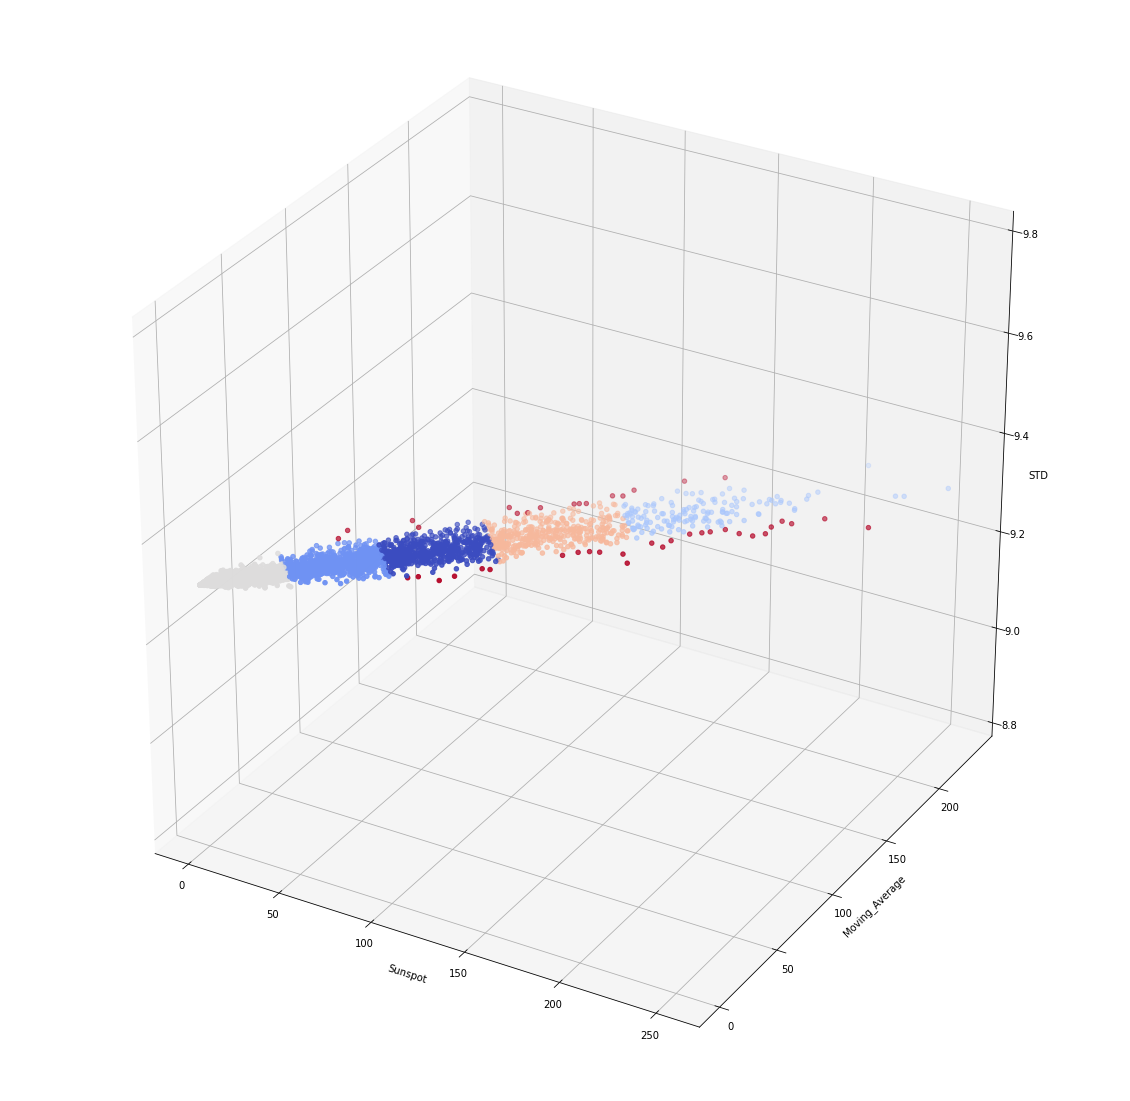

In [54]:
from mpl_toolkits.mplot3d import Axes3D
threedee = plt.figure(figsize=(20,20)).gca(projection='3d')

threedee.scatter(sunspot,moving_average,standard_deviation,c=prediction,cmap='coolwarm')
threedee.set_xlabel('Sunspot')
threedee.set_ylabel('Moving_Average')
threedee.set_zlabel('STD')
plt.show()